In [ ]:
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm

import requests
import io

def res_values(values, flag_res):
    res = values
    if flag_res:
        values_dif = np.roll(values, -1) - np.roll(values, 1)
        res = np.roll(values_dif, 0)/np.roll(values_dif, 1)
    return res

def func_sig(X, *p, flag_res):
    if flag_res:
        c1,c2,c3 = p
        AB = np.exp(c1*c2)
        A = np.exp(c1)
        AX = np.exp(c1*X)
        model = (A*AB+AX) / (AB + A*AX)
    else:
        c1,c2,c3 = p
        model = c3*(1/(1 + np.exp(-(c1 * (-c2 + X)))))
    return model

def plot_results(param):
    data = param['data']
    post_pred = param['post_pred']
    countries = param['countries']
    ylabel = param['ylabel']
    flag_res = param['flag_res']
    xlim = param['xlim']
    ylim = param['ylim'] 
    log_flag = param['log_flag']
    figsize = param['figsize']

    n_countries = len(countries)
    fig = plt.figure(figsize=figsize)
    colors = plt.cm.rainbow(np.linspace(0, 1, n_countries))
    plttype = 'Sigmoid-simulation-'
    
    for i, country in enumerate(countries):
        if flag_res:
            plttype = 'Growth-'
            fig = plt.figure(figsize=figsize)
        delay = np.argmin(np.abs(data[country+'-death'] - 17))
        delay = 0
        plt.scatter(data[country+'-day'] - delay, res_values(data[country+'-death'], flag_res), color=colors[i]                    
                    , edgecolors='black', linewidth=0.3,
                    label = country+' confirmed data', zorder=200)
                    
        plt.scatter(data[country+'-day'][-1] - delay, res_values(data[country+'-death'][-1], flag_res), color=colors[i]
                    , edgecolors='white', linewidth=1
                    , label = country+' today',zorder=200, marker = '*', s = 100)
        plt.plot(np.arange(0, post_pred[country].shape[1]) - delay, res_values(post_pred[country], flag_res).T, alpha=0.1, color=colors[i])
        p = [np.max(trace['c1'][:,i]),np.max(trace['c2'][:,i]),np.max(trace['c3'][:,i])]
        #plt.plot(np.linspace(0,60-1,60) - delay, func_sig(np.linspace(0,60-1,60), *p, flag_res = flag_res), alpha=1, color=colors[i])

        plt.xlabel('# Days from countries first death report')
        plt.ylabel(ylabel)
        
        cn = country
        if country == 'China':
            cn = 'Hubai'
            
        if cn in Dates.keys():
            for key, value in Dates[cn].items():
                ind = np.argwhere(data[country+'-date'] == key)[0][0]
                plt.plot([ind - delay,ind - delay],[0,15000], value[1], label = cn+'-'+ value[0], color=colors[i])

        plt.ylim(ylim)
        plt.xlim(xlim)
        
        if flag_res:
            lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), fancybox=True, shadow=True, ncol=6)
            plt.savefig('../images/'+plttype+country+'.png', dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')

    plt.grid(alpha=0.2)

    lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), fancybox=True, shadow=True, ncol=6)
    name = 'linear'
    
    if log_flag: 
        plt.yscale('log')
        name = 'log'
    if ~flag_res:    
        plt.savefig('../images/'+plttype+name+'.png', dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')

def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5):
    plt.style.use('dark_background')
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['color'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)
            plt.grid(alpha=0.2)
        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        
        legends.append(name)
        #if k_is_color:
        color=k_is_color[name]
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            #color='1',
        )
        
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            #color='1',            
            vertical=True
        )
        sns.set_style("whitegrid", {'axes.grid' : False})
    plt.legend(legends)
    plt.savefig('../images/'+'parameters'+'-'+cn[0]+'-'+cn[1]+'.png', dpi=100)
   
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
df_data = pd.read_csv(url, error_bad_lines=False)


countries = ['China', 'Iran','Italy','Spain']#,'Europe']
th = 2

data = {}
data_table = {}
for country in df_data['Country/Region'].unique():
    if country == 'Europe':
        select = ['Italy','Spain','Germany','France'] 
    else:
        select = [country]
    value = df_data[df_data['Country/Region'].isin(select)].drop(['Province/State','Country/Region','Lat','Long'], axis=1).sum(axis=0)
    value = value[value >= th] 
    data[country+'-death'] = value.values
    days = len(data[country+'-death'])
    data[country+'-day'] = np.linspace(0,days-1,days)
    data[country+'-date'] = value.index.values
    if len(data[country+'-death']) > 2:
        Growthr = (data[country+'-death'][-1]-data[country+'-death'][-2])/data[country+'-death'][-2]
        Growthf = (data[country+'-death'][-1]-data[country+'-death'][-2])/(data[country+'-death'][-2]-data[country+'-death'][-3])

        data_table[country] = [data[country+'-date'][-1],data[country+'-day'][-1],data[country+'-death'][-1],Growthr*100,Growthf]

        

html_content = pd.DataFrame.from_dict(data_table, orient='index', 
                       columns = ['Date last Update','# days', '# deaths',  'Growth Rate'
                        , 'Growth Factor']).sort_values(by=['# deaths'], ascending = False).to_html().replace('\n', '')
html_file = open("../tables/tabledata.html", "wt")
html_file.write(html_content)
html_file.close()


Dates = {'Spain':{'3/8/20':['M8','-.'],'3/13/20':['Lockdown','--']},
'Italy':{'3/9/20':['Lockdown','--']},
'Hubai':{'1/23/20':['Lockdown','--']}}

n_countries = len(countries)

flag_simulate = False
if flag_simulate:
    #hide
    with pm.Model() as model:
        ############
        # Intercept
        # Group mean
        clim = {}

        clim['c1s'] = 0.5
        clim['c1M'] = 0.5

        clim['c2s'] = 25
        clim['c2M'] = 25

        clim['c3s'] = 3500
        clim['c3M'] = 8000

        const = {}
        for cn in ['c1','c2','c3']:
            grp = pm.Normal(cn+'grp', clim[cn+'M'], clim[cn+'s'])
            # Group variance
            grp_sigma = pm.HalfNormal(cn+'grp_sigma', clim[cn+'s'])
            # Individual intercepts
            const[cn] = pm.Normal(cn,  mu=grp, sigma=grp_sigma,  shape=n_countries)

        # Error
        sigma = pm.HalfNormal('sigma', 500., shape=n_countries)

        # Create likelihood for each country
        for i, country in enumerate(countries):
            print(country)
            # By using pm.Data we can change these values after sampling.
            # This allows us to extend x into the future so we can get
            # forecasts by sampling from the posterior predictive
            x = pm.Data(country + "-x",  data[country+'-day'])
            cases = pm.Data(country + "-y",  data[country+'-death'])

            # Likelihood
            pm.NegativeBinomial(
                country, 
                const['c3'][i]*(1/(1 + np.exp(-(const['c1'][i] * (-const['c2'][i] + x))))),
                sigma[i], 
                observed=cases)


    ############################################  
    #hide
    with model:
        # Sample posterior
        trace = pm.sample(tune=3000, chains=1, cores=1, target_accept=.9)

        # Update data so that we get predictions into the future
        for country in countries:
            x_data = np.arange(0, 60)
            y_data = np.array([np.nan] * len(x_data))
            pm.set_data({country + "-x": x_data})
            pm.set_data({country + "-y": y_data})

        # Sample posterior predictive
        post_pred = pm.sample_posterior_predictive(trace, samples=100)
    ############################################ 



############################################ 

# write to html
# pm.summary(trace)

############################################     
        
    
GrowthR = {}
GrowthR['data'] = data
GrowthR['post_pred'] = post_pred
GrowthR['countries'] = countries
GrowthR['ylabel'] = 'Growth factor'
GrowthR['flag_res'] = True
GrowthR['xlim'] = [0,data['China'+'-day'][-1] + 2]
GrowthR['ylim'] = [0,5]
GrowthR['log_flag'] = False
GrowthR['figsize'] = (12, 6)

Sigmoid = {}
Sigmoid['data'] = data
Sigmoid['post_pred'] = post_pred
Sigmoid['countries'] = countries
Sigmoid['ylabel'] = 'Total-deaths'
Sigmoid['flag_res'] = False
Sigmoid['xlim'] = [0,data['China'+'-day'][-1] + 2]
Sigmoid['ylim'] = [0,10000]
Sigmoid['log_flag'] = False
Sigmoid['figsize'] = (17, 7)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.style.use('dark_background')

plot_results(Sigmoid)
Sigmoid['ylim'] = [10,10000]
Sigmoid['log_flag'] = True
plot_results(Sigmoid)

plot_results(GrowthR)


    
#hide_input

clabel = {'c1':'Growth','c2':'Inflexion day','c3':'Total number of deaths'}

colors = plt.cm.rainbow(np.linspace(0, 1, len(countries)))
colors_dic = {}                        
for i in range(0, len(countries)):
    colors_dic[countries[i]] = colors[i]
for k, cn in enumerate([['c1','c2'],['c3','c1'],['c3','c2']]):
    dfs = []
    for i, country in enumerate(countries):
        df = pd.DataFrame(np.append(trace[cn[0]][:, i],trace[cn[1]][:, i]).reshape(2,-1).T, columns=[clabel[cn[0]],clabel[cn[1]]])
        df['country'] = country
        dfs += [df]
    df=pd.concat(dfs)
    multivariateGrid(clabel[cn[0]],clabel[cn[1]], 'country', df=df, k_is_color = colors_dic)
    

In [6]:
df_html

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Date last Update</th>      <th># days</th>      <th># deaths</th>      <th>Growth Rate</th>      <th>Growth Factor</th>    </tr>  </thead>  <tbody>    <tr>      <th>China</th>      <td>3/16/20</td>      <td>54.0</td>      <td>3217</td>      <td>0.437090</td>      <td>1.400000</td>    </tr>    <tr>      <th>Italy</th>      <td>3/16/20</td>      <td>23.0</td>      <td>2158</td>      <td>19.292427</td>      <td>0.948370</td>    </tr>    <tr>      <th>Iran</th>      <td>3/16/20</td>      <td>26.0</td>      <td>853</td>      <td>17.817680</td>      <td>1.141593</td>    </tr>    <tr>      <th>Spain</th>      <td>3/16/20</td>      <td>12.0</td>      <td>342</td>      <td>18.339100</td>      <td>0.563830</td>    </tr>    <tr>      <th>France</th>      <td>3/16/20</td>      <td>19.0</td>      <td>148</td>      <td>62.637363</td>      <td>inf</td>    </tr>    <tr>      <th>US</th>      <td>3

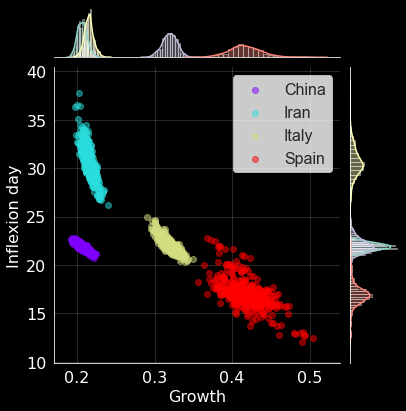

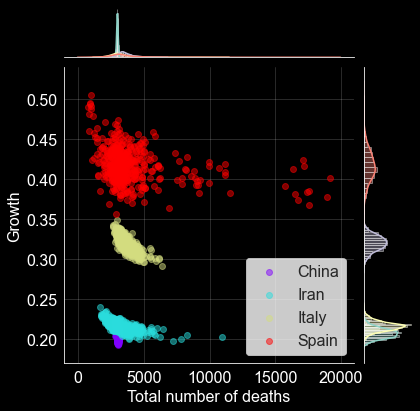

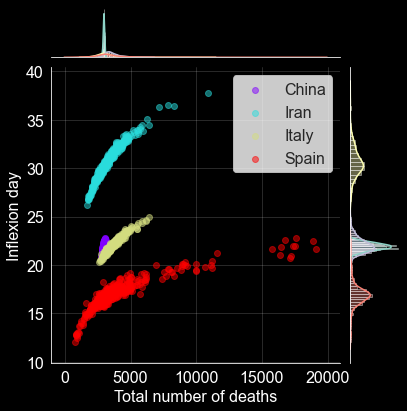

In [28]:
#hide_input
#hide_input



clabel = {'c1':'Growth','c2':'Inflexion day','c3':'Total number of deaths'}

colors = plt.cm.rainbow(np.linspace(0, 1, len(countries)))
colors_dic = {}                        
for i in range(0, len(countries)):
    colors_dic[countries[i]] = colors[i]
for k, cn in enumerate([['c1','c2'],['c3','c1'],['c3','c2']]):
    dfs = []
    for i, country in enumerate(countries):
        df = pd.DataFrame(np.append(trace[cn[0]][:, i],trace[cn[1]][:, i]).reshape(2,-1).T, columns=[clabel[cn[0]],clabel[cn[1]]])
        df['country'] = country
        dfs += [df]
    df=pd.concat(dfs)
    multivariateGrid(clabel[cn[0]],clabel[cn[1]], 'country', df=df, k_is_color = colors_dic)
    